In [1]:
import json
import joblib
import os
import time
import random
import gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt
from sklearn.metrics import (
r2_score,
mean_absolute_error,
root_mean_squared_error,
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import shap
from sklearn.cluster import KMeans


In [2]:
# ====== Config ======
SEED = 42
BATCH_SIZE = 512
MAX_EPOCHS_TUNER = 200 # tuner 
EPOCHS_FINAL = 1000 # entrenamiento final con los mejores HP
ES_PATIENCE = 50
RLROP_PATIENCE = 15
RLROP_FACTOR = 0.5
MIN_LR = 1e-6
TEST_SIZE = 0.2
VAL_SIZE = 0.2


### Primer modelo MLP --> Control: Sin VCR ni coordenadas

In [3]:
# Configuración básica del dataset
df_vcr_c = pd.read_csv('dataset_vcr_compact.csv')
df_vcr_c = df_vcr_c[df_vcr_c['monto'] < 56000].copy()
df_vcr_c['log_monto']=np.log(df_vcr_c['monto'])
df_vcr_c['log_monto'].describe()

count    25211.000000
mean         8.395828
std          0.830310
min          5.950643
25%          7.740664
50%          8.242756
75%          8.984694
max         10.915088
Name: log_monto, dtype: float64

In [4]:
#Configuración específica del modelo
df_base =df_vcr_c.copy()
obj_cols = df_base.select_dtypes(include=["object"]).columns
cols_to_drop = list(obj_cols) + ["id", "latitud", "longitud"]
df_base = df_base.drop(columns=cols_to_drop)
df_base.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Index: 25211 entries, 0 to 25214
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   monto                 25211 non-null  int64  
 1   superficie_t          25211 non-null  float64
 2   dormitorios           25211 non-null  int64  
 3   dormitorios_faltante  25211 non-null  int64  
 4   banos                 25211 non-null  int64  
 5   banos_faltante        25211 non-null  int64  
 6   antiguedad            25211 non-null  int64  
 7   antiguedad_faltante   25211 non-null  int64  
 8   Or_N                  25211 non-null  int64  
 9   Or_S                  25211 non-null  int64  
 10  Or_E                  25211 non-null  int64  
 11  Or_O                  25211 non-null  int64  
 12  Or_Faltante           25211 non-null  int64  
 13  terraza               25211 non-null  float64
 14  estacionamiento       25211 non-null  int64  
 15  bodegas               25

In [5]:
# Split
X_df = df_base.drop(columns=["monto", "log_monto"]).copy()
y = df_base["log_monto"].values.astype(np.float32)

X_train_full, X_test, y_train_full, y_test = train_test_split(
    X_df.values, y, test_size=TEST_SIZE, random_state=SEED
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=VAL_SIZE, random_state=SEED
)

scaler = StandardScaler().fit(X_train) #(x - mean)/std. --> mean = 0, std = 1
X_train = scaler.transform(X_train).astype(np.float32)
X_val = scaler.transform(X_val).astype(np.float32)
X_test = scaler.transform(X_test).astype(np.float32)

n_features = X_train.shape[1]
print(f"n_features: {n_features}")

n_features: 21


In [6]:
# ====== Utilidades ======
def build_model(hp: kt.HyperParameters) -> keras.Model:
    n_features = X_train.shape[1]
    inputs = keras.Input(shape=(n_features,), name="features")

    x = inputs
    # Capas ocultas
    n_layers = hp.Int("n_layers", min_value=1, max_value=4, step=1)
    for i in range(n_layers):
        units = hp.Int(f"units_{i}", min_value=64, max_value=512, step=64)
        dropout = hp.Choice(f"dropout_{i}", values=[0.0, 0.1, 0.2, 0.3])
        l2 = hp.Choice(f"l2_{i}", values=[0.0, 1e-6, 1e-5, 1e-4])
        x = keras.layers.Dense(units, activation="gelu", kernel_regularizer=keras.regularizers.l2(l2))(x)
        if dropout > 0:
            x = keras.layers.Dropout(dropout)(x)

    outputs = keras.layers.Dense(1, name="log_monto")(x)
    model = keras.Model(inputs, outputs)

    lr = hp.Choice("lr", values=[1e-3, 5e-4, 3e-4, 1e-4])
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr, clipnorm=1.0), loss="mse")
    return model



In [7]:
PROJECT_NAME = "mlp_v1"

def reset_tf(seed=42):
    tf.keras.backend.clear_session()
    gc.collect()
    np.random.seed(seed); random.seed(seed); tf.random.set_seed(seed)

reset_tf(SEED)

In [8]:
# ====== Tuning ======
callbacks_tuner = [
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=ES_PATIENCE, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=RLROP_FACTOR, patience=RLROP_PATIENCE, min_lr=MIN_LR),
]
DATASET_TAG = "ds1"  
RUN_TAG = f"{PROJECT_NAME}_{DATASET_TAG}_{int(time.time())}"
tuner = kt.Hyperband(
    hypermodel=build_model,
    objective=kt.Objective("val_loss", direction="min"),
    max_epochs=MAX_EPOCHS_TUNER,
    factor=3,
    seed=SEED,
    directory="kt_logs", 
    project_name=PROJECT_NAME,
    overwrite=True,
)

start = time.perf_counter()
tuner.search(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=MAX_EPOCHS_TUNER,
    batch_size=BATCH_SIZE,
    callbacks=callbacks_tuner,
    verbose=0,
)
tuning_time = time.perf_counter() - start
print(f"Tuning terminado en {tuning_time:.2f} s | trials: {len(tuner.get_best_hyperparameters())}")

best_hp = tuner.get_best_hyperparameters(1)[0]
model = tuner.hypermodel.build(best_hp)

Tuning terminado en 2128.61 s | trials: 1


In [9]:
# ====== Entrenamiento final con mejor HP ======
ckpt_cb = keras.callbacks.ModelCheckpoint(
        "models/best_model_mlp_v1.keras",
        monitor="val_loss", save_best_only=True
        )
callbacks_train = [
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=ES_PATIENCE, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=RLROP_FACTOR, patience=RLROP_PATIENCE, min_lr=MIN_LR),
    ckpt_cb,
    ]

history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS_FINAL,
    batch_size=BATCH_SIZE,
    callbacks=callbacks_train,
    verbose=1,
)

# ====== Métricas ======
def eval_all_splits(model, Xtr, ytr, Xva, yva, Xte, yte):
    def _pred(X):
        return np.asarray(model.predict(X, verbose=0)).reshape(-1)

    ytr_pred_log = _pred(Xtr)
    yva_pred_log = _pred(Xva)
    yte_pred_log = _pred(Xte)

    # LOG
    r2_tr = r2_score(ytr, ytr_pred_log)
    r2_va = r2_score(yva, yva_pred_log)
    r2_te = r2_score(yte, yte_pred_log)

    rmse_log_tr = float(np.sqrt(np.mean((ytr - ytr_pred_log) ** 2)))
    rmse_log_va = float(np.sqrt(np.mean((yva - yva_pred_log) ** 2)))
    rmse_log_te = float(np.sqrt(np.mean((yte - yte_pred_log) ** 2)))

    mae_log_tr = mean_absolute_error(ytr, ytr_pred_log)
    mae_log_va = mean_absolute_error(yva, yva_pred_log)
    mae_log_te = mean_absolute_error(yte, yte_pred_log)

    # UF
    ytr_price = np.exp(ytr)
    yva_price = np.exp(yva)
    yte_price = np.exp(yte)

    ytr_pred_price = np.exp(ytr_pred_log)
    yva_pred_price = np.exp(yva_pred_log)
    yte_pred_price = np.exp(yte_pred_log)

    rmse_tr = root_mean_squared_error(ytr_price, ytr_pred_price)
    rmse_va = root_mean_squared_error(yva_price, yva_pred_price)
    rmse_te = root_mean_squared_error(yte_price, yte_pred_price)

    mae_tr  = mean_absolute_error(ytr_price, ytr_pred_price)
    mae_va  = mean_absolute_error(yva_price, yva_pred_price)
    mae_te  = mean_absolute_error(yte_price, yte_pred_price)

    mape_tr = float(np.mean(np.abs((ytr_price - ytr_pred_price) / np.clip(ytr_price, 1e-9, None))) * 100)
    mape_va = float(np.mean(np.abs((yva_price - yva_pred_price) / np.clip(yva_price, 1e-9, None))) * 100)
    mape_te = float(np.mean(np.abs((yte_price - yte_pred_price) / np.clip(yte_price, 1e-9, None))) * 100)

    return {
        "log": {
            "r2": (r2_tr, r2_va, r2_te),
            "rmse": (rmse_log_tr, rmse_log_va, rmse_log_te),
            "mae": (mae_log_tr, mae_log_va, mae_log_te),
        },
        "uf": {
            "rmse": (rmse_tr, rmse_va, rmse_te),
            "mae": (mae_tr, mae_va, mae_te),
            "mape": (mape_tr, mape_va, mape_te),
        },
    }

metrics = eval_all_splits(model, X_train, y_train, X_val, y_val, X_test, y_test)

print("\n=== MLP (Keras Tuner) ===")
print(">> LOG space")
print(f"Train: R^2={metrics['log']['r2'][0]:.4f} | RMSE={metrics['log']['rmse'][0]:.4f} | MAE={metrics['log']['mae'][0]:.4f}")
print(f"Val  : R^2={metrics['log']['r2'][1]:.4f} | RMSE={metrics['log']['rmse'][1]:.4f} | MAE={metrics['log']['mae'][1]:.4f}")
print(f"Test : R^2={metrics['log']['r2'][2]:.4f} | RMSE={metrics['log']['rmse'][2]:.4f} | MAE={metrics['log']['mae'][2]:.4f}")

print(">> UF space (precio)")
print(f"Train: RMSE={metrics['uf']['rmse'][0]:,.2f} | MAE={metrics['uf']['mae'][0]:,.2f} | MAPE={metrics['uf']['mape'][0]:.2f}%")
print(f"Val  : RMSE={metrics['uf']['rmse'][1]:,.2f} | MAE={metrics['uf']['mae'][1]:,.2f} | MAPE={metrics['uf']['mape'][1]:.2f}%")
print(f"Test : RMSE={metrics['uf']['rmse'][2]:,.2f} | MAE={metrics['uf']['mae'][2]:,.2f} | MAPE={metrics['uf']['mape'][2]:.2f}%")

# ====== Historial para gráficos ======
history_mlp = {
    "loss": history.history.get("loss", []),
    "val_loss": history.history.get("val_loss", []),
}



Epoch 1/1000
32/32 [==============================] - 2s 22ms/step - loss: 40.4771 - val_loss: 10.3470 - lr: 0.0010
Epoch 2/1000
32/32 [==============================] - 0s 13ms/step - loss: 3.2558 - val_loss: 0.3750 - lr: 0.0010
Epoch 3/1000
32/32 [==============================] - 0s 12ms/step - loss: 0.3506 - val_loss: 0.1560 - lr: 0.0010
Epoch 4/1000
32/32 [==============================] - 0s 12ms/step - loss: 0.2066 - val_loss: 0.1229 - lr: 0.0010
Epoch 5/1000
32/32 [==============================] - 0s 13ms/step - loss: 0.1780 - val_loss: 0.1096 - lr: 0.0010
Epoch 6/1000
32/32 [==============================] - 0s 10ms/step - loss: 0.1666 - val_loss: 0.1128 - lr: 0.0010
Epoch 7/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.1561 - val_loss: 0.0993 - lr: 0.0010
Epoch 8/1000
32/32 [==============================] - 0s 15ms/step - loss: 0.1485 - val_loss: 0.0931 - lr: 0.0010
Epoch 9/1000
32/32 [==============================] - 0s 12ms/step - loss: 0.1417 - va

In [10]:
os.makedirs("models", exist_ok=True)

best_hp = tuner.get_best_hyperparameters(1)[0]
with open("models/best_hp_mlp_v1.json", "w") as f:
    json.dump(best_hp.values, f, indent=2)
print("Guardado: models/best_hp_mlp_v1.json")

model.save("models/best_model_mlp_v1.keras")
print("Guardado: models/best_model_mlp_v1.keras")

joblib.dump(scaler, "models/scaler_mlp_v1.joblib")
print("Guardado: models/scaler_mlp_v1.joblib")

feature_names = list(X_df.columns)
with open("models/feature_names_mlp_v1.json","w") as f:
    json.dump(feature_names, f, indent=2)
print("Guardado: models/feature_names_mlp_v1.json")

Guardado: models/best_hp_mlp_v1.json
Guardado: models/best_model_mlp_v1.keras
Guardado: models/scaler_mlp_v1.joblib
Guardado: models/feature_names_mlp_v1.json


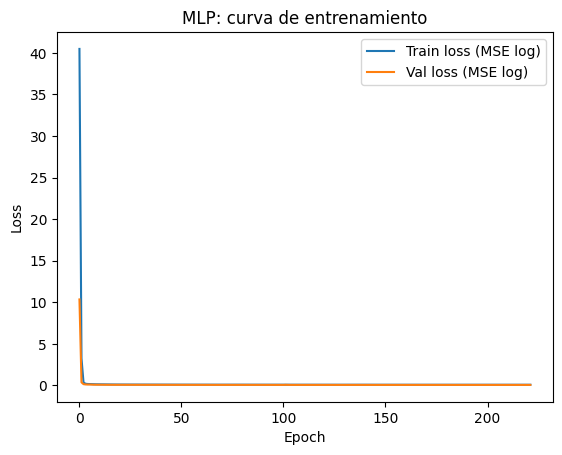

In [ ]:
plt.figure()
plt.plot(history_mlp["loss"], label="Train loss (MSE log)")
plt.plot(history_mlp["val_loss"], label="Val loss (MSE log)")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("MLP: curva de entrenamiento"); plt.legend(); plt.show()

In [12]:
# ====== SHAP (robusto a versiones) ======
try:
    feature_names = list(X_df.columns)
except Exception:
    feature_names = [f"f{i}" for i in range(X_train.shape[1])]
    
NSAMPLES = 200  # número de evaluaciones por muestra en KernelExplainer

# submuestras (parametrizables)
BG_K = min(256, X_train.shape[0])   # prototipos k-means ~256
EX_N = min(512, X_test.shape[0])    # explicaciones ~512

# background representativo: prototipos k-means
try:
    background = shap.kmeans(X_train, BG_K)
except Exception:
    km = KMeans(n_clusters=BG_K, n_init=5, random_state=SEED).fit(X_train)
    background = km.cluster_centers_.astype(np.float32)

explain_X = X_test[:EX_N].astype(np.float32)

# Normalizar 'background' a ndarray (shap.kmeans -> DenseData)
if hasattr(background, "data"):  # DenseData
    background_np = np.asarray(background.data, dtype=np.float32)
else:  # ya es ndarray (p. ej., KMeans)
    background_np = background.astype(np.float32)

assert background_np.ndim == 2 and explain_X.ndim == 2

t0 = time.perf_counter()
f_pred = lambda z: model.predict(z, verbose=0).ravel()
explainer = shap.KernelExplainer(f_pred, background_np, link="identity")
sv = explainer.shap_values(explain_X, nsamples=NSAMPLES)
shap_vals = sv[0] if isinstance(sv, list) else sv
shap_vals = np.asarray(shap_vals, dtype=np.float32)

# normalizar forma a (n_samples, n_features)
if shap_vals.ndim == 1:
    shap_vals = shap_vals.reshape(-1, 1)
if shap_vals.shape[0] != explain_X.shape[0] and shap_vals.shape[1] == explain_X.shape[0]:
    shap_vals = shap_vals.T
print(
    f"[SHAP] backend=kernel | bg_n={background_np.shape[0]} | "
    f"ex_n={explain_X.shape[0]} | nsamples={NSAMPLES} | time={time.perf_counter()-t0:.2f}s"
)

# Importancias
imp = np.mean(np.abs(shap_vals), axis=0)
order = np.argsort(imp)[::-1]
top_k = 20
shap_summary = pd.DataFrame({
    "feature": np.array(feature_names)[order][:top_k],
    "mean_|shap|": imp[order][:top_k],
})
print("\nTop-20 features por |SHAP| (MLP):")
print(shap_summary.to_string(index=False))

shap_data = {
    "feature_names": feature_names,
    "importances": imp,
    "order": order,
    "topk_df": shap_summary,
}


Using 256 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/512 [00:00<?, ?it/s]

[SHAP] backend=kernel | bg_n=256 | ex_n=512 | nsamples=200 | time=2289.96s

Top-20 features por |SHAP| (MLP):
            feature  mean_|shap|
       superficie_t     0.466508
  flag_Departamento     0.207392
              banos     0.167089
      flag_Semipiso     0.078939
    estacionamiento     0.066016
            terraza     0.046452
        dormitorios     0.044713
            bodegas     0.038915
    flag_Multinivel     0.038695
       flag_Premium     0.022763
          flag_Loft     0.016955
               Or_O     0.014224
  flag_Monoambiente     0.013813
         antiguedad     0.012598
        Or_Faltante     0.011843
     banos_faltante     0.010923
               Or_E     0.009099
               Or_S     0.006062
antiguedad_faltante     0.004155
               Or_N     0.003754


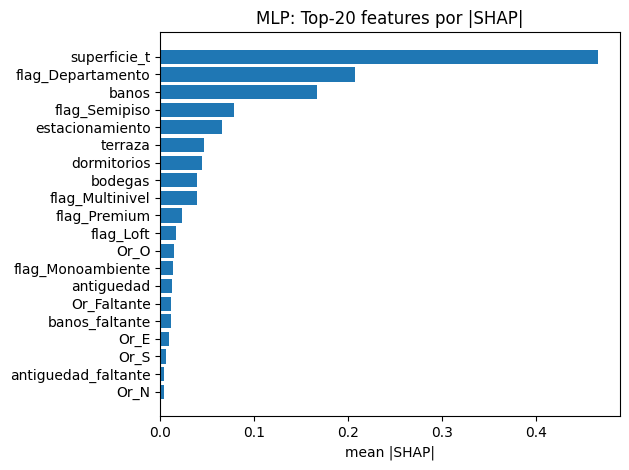

In [13]:
# Top-K SHAP bar
if shap_data:
    top = shap_data["topk_df"]
    plt.figure()
    plt.barh(top["feature"][::-1], top["mean_|shap|"][::-1])
    plt.xlabel("mean |SHAP|"); plt.title("MLP: Top-20 features por |SHAP|"); plt.tight_layout(); plt.show()

In [14]:
# (Opcional y recomendable entre datasets)
del tuner  # libera memoria de trials
gc.collect()
del model
reset_tf(SEED) 


### Segundo modelo MLP --> Con coordenadas, sin VCR

In [15]:
# Configuración específica del modelo
df_coord =df_vcr_c.copy()
obj_cols = df_coord.select_dtypes(include=["object"]).columns
cols_to_drop = list(obj_cols)
cols_to_drop.append("id")
df_coord = df_coord.drop(columns=cols_to_drop)
df_coord.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Index: 25211 entries, 0 to 25214
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   monto                 25211 non-null  int64  
 1   superficie_t          25211 non-null  float64
 2   dormitorios           25211 non-null  int64  
 3   dormitorios_faltante  25211 non-null  int64  
 4   banos                 25211 non-null  int64  
 5   banos_faltante        25211 non-null  int64  
 6   antiguedad            25211 non-null  int64  
 7   antiguedad_faltante   25211 non-null  int64  
 8   Or_N                  25211 non-null  int64  
 9   Or_S                  25211 non-null  int64  
 10  Or_E                  25211 non-null  int64  
 11  Or_O                  25211 non-null  int64  
 12  Or_Faltante           25211 non-null  int64  
 13  terraza               25211 non-null  float64
 14  estacionamiento       25211 non-null  int64  
 15  bodegas               25

In [16]:
# Split
X_df = df_coord.drop(columns=["monto", "log_monto"]).copy()
y = df_coord["log_monto"].values.astype(np.float32)

X_train_full, X_test, y_train_full, y_test = train_test_split(
    X_df.values, y, test_size=TEST_SIZE, random_state=SEED
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=VAL_SIZE, random_state=SEED
)

scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train).astype(np.float32)
X_val = scaler.transform(X_val).astype(np.float32)
X_test = scaler.transform(X_test).astype(np.float32)

n_features = X_train.shape[1]
print(f"n_features: {n_features}")

n_features: 23


In [17]:
# ====== Utilidades ======
def build_model(hp: kt.HyperParameters) -> keras.Model:
    n_features = X_train.shape[1]
    inputs = keras.Input(shape=(n_features,), name="features")

    x = inputs
    # Capas ocultas
    n_layers = hp.Int("n_layers", min_value=1, max_value=4, step=1)
    for i in range(n_layers):
        units = hp.Int(f"units_{i}", min_value=64, max_value=512, step=64)
        dropout = hp.Choice(f"dropout_{i}", values=[0.0, 0.1, 0.2, 0.3])
        l2 = hp.Choice(f"l2_{i}", values=[0.0, 1e-6, 1e-5, 1e-4])
        x = keras.layers.Dense(units, activation="gelu", kernel_regularizer=keras.regularizers.l2(l2))(x)
        if dropout > 0:
            x = keras.layers.Dropout(dropout)(x)

    outputs = keras.layers.Dense(1, name="log_monto")(x)
    model = keras.Model(inputs, outputs)

    lr = hp.Choice("lr", values=[1e-3, 5e-4, 3e-4, 1e-4])
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr, clipnorm=1.0), loss="mse")
    return model



In [18]:
PROJECT_NAME = "mlp_v2"

def reset_tf(seed=42):
    tf.keras.backend.clear_session()
    gc.collect()
    np.random.seed(seed); random.seed(seed); tf.random.set_seed(seed)

reset_tf(SEED)

In [19]:
# ====== Tuning ======
callbacks_tuner = [
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=ES_PATIENCE, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=RLROP_FACTOR, patience=RLROP_PATIENCE, min_lr=MIN_LR),
]
DATASET_TAG = "ds2"  
RUN_TAG = f"{PROJECT_NAME}_{DATASET_TAG}_{int(time.time())}"
tuner = kt.Hyperband(
    hypermodel=build_model,
    objective=kt.Objective("val_loss", direction="min"),
    max_epochs=MAX_EPOCHS_TUNER,
    factor=3,
    seed=SEED,
    directory="kt_logs", 
    project_name=PROJECT_NAME,
    overwrite=True,
)

start = time.perf_counter()
tuner.search(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=MAX_EPOCHS_TUNER,
    batch_size=BATCH_SIZE,
    callbacks=callbacks_tuner,
    verbose=0,
)
tuning_time = time.perf_counter() - start
print(f"Tuning terminado en {tuning_time:.2f} s | trials: {len(tuner.get_best_hyperparameters())}")

best_hp = tuner.get_best_hyperparameters(1)[0]
model = tuner.hypermodel.build(best_hp)

Tuning terminado en 2240.77 s | trials: 1


In [20]:
# ====== Entrenamiento final con mejor HP ======
ckpt_cb = keras.callbacks.ModelCheckpoint(
        "models/best_model_mlp_v2.keras",
        monitor="val_loss", save_best_only=True
        )
callbacks_train = [
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=ES_PATIENCE, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=RLROP_FACTOR, patience=RLROP_PATIENCE, min_lr=MIN_LR),
    ckpt_cb,
    ]

history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS_FINAL,
    batch_size=BATCH_SIZE,
    callbacks=callbacks_train,
    verbose=1,
)

# ====== Métricas ======
def eval_all_splits(model, Xtr, ytr, Xva, yva, Xte, yte):
    def _pred(X):
        return np.asarray(model.predict(X, verbose=0)).reshape(-1)

    ytr_pred_log = _pred(Xtr)
    yva_pred_log = _pred(Xva)
    yte_pred_log = _pred(Xte)

    # LOG
    r2_tr = r2_score(ytr, ytr_pred_log)
    r2_va = r2_score(yva, yva_pred_log)
    r2_te = r2_score(yte, yte_pred_log)

    rmse_log_tr = float(np.sqrt(np.mean((ytr - ytr_pred_log) ** 2)))
    rmse_log_va = float(np.sqrt(np.mean((yva - yva_pred_log) ** 2)))
    rmse_log_te = float(np.sqrt(np.mean((yte - yte_pred_log) ** 2)))

    mae_log_tr = mean_absolute_error(ytr, ytr_pred_log)
    mae_log_va = mean_absolute_error(yva, yva_pred_log)
    mae_log_te = mean_absolute_error(yte, yte_pred_log)

    # UF
    ytr_price = np.exp(ytr)
    yva_price = np.exp(yva)
    yte_price = np.exp(yte)

    ytr_pred_price = np.exp(ytr_pred_log)
    yva_pred_price = np.exp(yva_pred_log)
    yte_pred_price = np.exp(yte_pred_log)

    rmse_tr = root_mean_squared_error(ytr_price, ytr_pred_price)
    rmse_va = root_mean_squared_error(yva_price, yva_pred_price)
    rmse_te = root_mean_squared_error(yte_price, yte_pred_price)

    mae_tr  = mean_absolute_error(ytr_price, ytr_pred_price)
    mae_va  = mean_absolute_error(yva_price, yva_pred_price)
    mae_te  = mean_absolute_error(yte_price, yte_pred_price)

    mape_tr = float(np.mean(np.abs((ytr_price - ytr_pred_price) / np.clip(ytr_price, 1e-9, None))) * 100)
    mape_va = float(np.mean(np.abs((yva_price - yva_pred_price) / np.clip(yva_price, 1e-9, None))) * 100)
    mape_te = float(np.mean(np.abs((yte_price - yte_pred_price) / np.clip(yte_price, 1e-9, None))) * 100)

    return {
        "log": {
            "r2": (r2_tr, r2_va, r2_te),
            "rmse": (rmse_log_tr, rmse_log_va, rmse_log_te),
            "mae": (mae_log_tr, mae_log_va, mae_log_te),
        },
        "uf": {
            "rmse": (rmse_tr, rmse_va, rmse_te),
            "mae": (mae_tr, mae_va, mae_te),
            "mape": (mape_tr, mape_va, mape_te),
        },
    }

metrics = eval_all_splits(model, X_train, y_train, X_val, y_val, X_test, y_test)

print("\n=== MLP (Keras Tuner) ===")
print(">> LOG space")
print(f"Train: R^2={metrics['log']['r2'][0]:.4f} | RMSE={metrics['log']['rmse'][0]:.4f} | MAE={metrics['log']['mae'][0]:.4f}")
print(f"Val  : R^2={metrics['log']['r2'][1]:.4f} | RMSE={metrics['log']['rmse'][1]:.4f} | MAE={metrics['log']['mae'][1]:.4f}")
print(f"Test : R^2={metrics['log']['r2'][2]:.4f} | RMSE={metrics['log']['rmse'][2]:.4f} | MAE={metrics['log']['mae'][2]:.4f}")

print(">> UF space (precio)")
print(f"Train: RMSE={metrics['uf']['rmse'][0]:,.2f} | MAE={metrics['uf']['mae'][0]:,.2f} | MAPE={metrics['uf']['mape'][0]:.2f}%")
print(f"Val  : RMSE={metrics['uf']['rmse'][1]:,.2f} | MAE={metrics['uf']['mae'][1]:,.2f} | MAPE={metrics['uf']['mape'][1]:.2f}%")
print(f"Test : RMSE={metrics['uf']['rmse'][2]:,.2f} | MAE={metrics['uf']['mae'][2]:,.2f} | MAPE={metrics['uf']['mape'][2]:.2f}%")

# ====== Historial para gráficos ======
history_mlp = {
    "loss": history.history.get("loss", []),
    "val_loss": history.history.get("val_loss", []),
}



Epoch 1/1000
32/32 [==============================] - 3s 21ms/step - loss: 46.3546 - val_loss: 11.1586 - lr: 3.0000e-04
Epoch 2/1000
32/32 [==============================] - 0s 14ms/step - loss: 2.9167 - val_loss: 0.1709 - lr: 3.0000e-04
Epoch 3/1000
32/32 [==============================] - 0s 13ms/step - loss: 0.2064 - val_loss: 0.0820 - lr: 3.0000e-04
Epoch 4/1000
32/32 [==============================] - 0s 13ms/step - loss: 0.1625 - val_loss: 0.0718 - lr: 3.0000e-04
Epoch 5/1000
32/32 [==============================] - 1s 16ms/step - loss: 0.1475 - val_loss: 0.0669 - lr: 3.0000e-04
Epoch 6/1000
32/32 [==============================] - 0s 14ms/step - loss: 0.1377 - val_loss: 0.0626 - lr: 3.0000e-04
Epoch 7/1000
32/32 [==============================] - 0s 15ms/step - loss: 0.1289 - val_loss: 0.0617 - lr: 3.0000e-04
Epoch 8/1000
32/32 [==============================] - 0s 12ms/step - loss: 0.1256 - val_loss: 0.0619 - lr: 3.0000e-04
Epoch 9/1000
32/32 [==============================] - 

In [21]:
os.makedirs("models", exist_ok=True)

best_hp = tuner.get_best_hyperparameters(1)[0]
with open("models/best_hp_mlp_v2.json", "w") as f:
    json.dump(best_hp.values, f, indent=2)
print("Guardado: models/best_hp_mlp_v2.json")

model.save("models/best_model_mlp_v2.keras")
print("Guardado: models/best_model_mlp_v2.keras")

joblib.dump(scaler, "models/scaler_mlp_v2.joblib")
print("Guardado: models/scaler_mlp_v2.joblib")

feature_names = list(X_df.columns)
with open("models/feature_names_mlp_v2.json","w") as f:
    json.dump(feature_names, f, indent=2)
print("Guardado: models/feature_names_mlp_v2.json")

Guardado: models/best_hp_mlp_v2.json
Guardado: models/best_model_mlp_v2.keras
Guardado: models/scaler_mlp_v2.joblib
Guardado: models/feature_names_mlp_v2.json


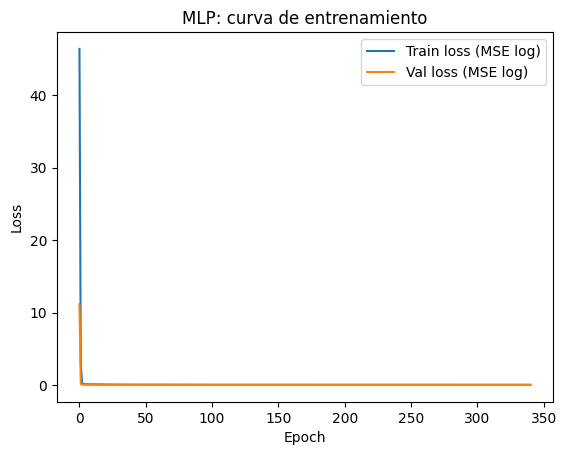

In [22]:
plt.figure()
plt.plot(history_mlp["loss"], label="Train loss (MSE log)")
plt.plot(history_mlp["val_loss"], label="Val loss (MSE log)")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("MLP: curva de entrenamiento"); plt.legend(); plt.show()


In [23]:
# ====== SHAP (robusto a versiones) ======
try:
    feature_names = list(X_df.columns)
except Exception:
    feature_names = [f"f{i}" for i in range(X_train.shape[1])]
    
NSAMPLES = 200  # número de evaluaciones por muestra en KernelExplainer

# submuestras (parametrizables)
BG_K = min(256, X_train.shape[0])   # prototipos k-means ~256
EX_N = min(512, X_test.shape[0])    # explicaciones ~512

# background representativo: prototipos k-means
try:
    background = shap.kmeans(X_train, BG_K)
except Exception:
    km = KMeans(n_clusters=BG_K, n_init=5, random_state=SEED).fit(X_train)
    background = km.cluster_centers_.astype(np.float32)

explain_X = X_test[:EX_N].astype(np.float32)

# Normalizar 'background' a ndarray (shap.kmeans -> DenseData)
if hasattr(background, "data"):  # DenseData
    background_np = np.asarray(background.data, dtype=np.float32)
else:  # ya es ndarray (p. ej., KMeans)
    background_np = background.astype(np.float32)

assert background_np.ndim == 2 and explain_X.ndim == 2

t0 = time.perf_counter()
f_pred = lambda z: model.predict(z, verbose=0).ravel()
explainer = shap.KernelExplainer(f_pred, background_np, link="identity")
sv = explainer.shap_values(explain_X, nsamples=NSAMPLES)
shap_vals = sv[0] if isinstance(sv, list) else sv
shap_vals = np.asarray(shap_vals, dtype=np.float32)

# normalizar forma a (n_samples, n_features)
if shap_vals.ndim == 1:
    shap_vals = shap_vals.reshape(-1, 1)
if shap_vals.shape[0] != explain_X.shape[0] and shap_vals.shape[1] == explain_X.shape[0]:
    shap_vals = shap_vals.T
print(
    f"[SHAP] backend=kernel | bg_n={background_np.shape[0]} | "
    f"ex_n={explain_X.shape[0]} | nsamples={NSAMPLES} | time={time.perf_counter()-t0:.2f}s"
)

# Importancias
imp = np.mean(np.abs(shap_vals), axis=0)
order = np.argsort(imp)[::-1]
top_k = 20
shap_summary = pd.DataFrame({
    "feature": np.array(feature_names)[order][:top_k],
    "mean_|shap|": imp[order][:top_k],
})
print("\nTop-20 features por |SHAP| (MLP con coordenadas):")
print(shap_summary.to_string(index=False))

shap_data = {
    "feature_names": feature_names,
    "importances": imp,
    "order": order,
    "topk_df": shap_summary,
}


Using 256 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/512 [00:00<?, ?it/s]

[SHAP] backend=kernel | bg_n=256 | ex_n=512 | nsamples=200 | time=2527.91s

Top-20 features por |SHAP| (MLP con coordenadas):
            feature  mean_|shap|
       superficie_t     0.337968
           longitud     0.218053
            latitud     0.096017
              banos     0.083167
    estacionamiento     0.052420
         antiguedad     0.032247
  flag_Departamento     0.025182
            bodegas     0.013825
            terraza     0.013585
        Or_Faltante     0.010092
      flag_Semipiso     0.008216
        dormitorios     0.007477
     banos_faltante     0.006844
               Or_O     0.005713
       flag_Premium     0.005367
               Or_S     0.004279
          flag_Loft     0.003819
antiguedad_faltante     0.003787
               Or_E     0.003160
    flag_Multinivel     0.003037


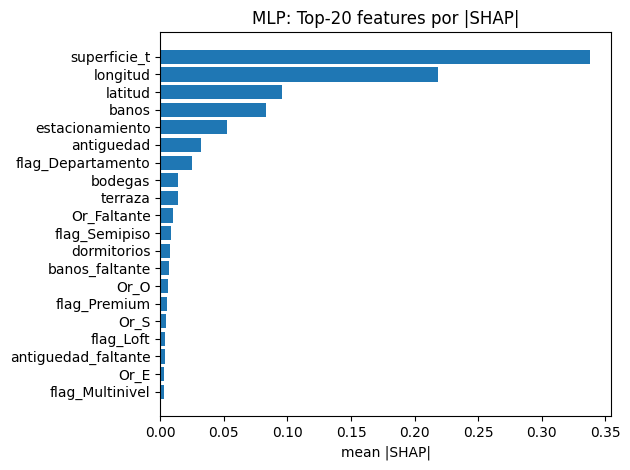

In [24]:
# Top-K SHAP bar
if shap_data:
    top = shap_data["topk_df"]
    plt.figure()
    plt.barh(top["feature"][::-1], top["mean_|shap|"][::-1])
    plt.xlabel("mean |SHAP|"); plt.title("MLP: Top-20 features por |SHAP|"); plt.tight_layout(); plt.show()

In [25]:
# (Opcional y recomendable entre datasets)
del tuner  # libera memoria de trials
gc.collect()
del model
reset_tf(SEED) 

### Tercer modelo MLP --> Con coordenadas y VCR

In [3]:
df_vcr_e = pd.read_csv('dataset_vcr_expanded.csv')
df_vcr_e = df_vcr_e[df_vcr_e['monto'] < 56000].copy()
df_vcr_e['log_monto']=np.log(df_vcr_e['monto'])
df_vcr_e['log_monto'].describe()

count    25211.000000
mean         8.395828
std          0.830310
min          5.950643
25%          7.740664
50%          8.242756
75%          8.984694
max         10.915088
Name: log_monto, dtype: float64

In [4]:
df_vcr =df_vcr_e.copy()
obj_cols = df_vcr.select_dtypes(include=["object"]).columns
cols_to_drop = list(obj_cols)
cols_to_drop.append("id")
df_vcr = df_vcr.drop(columns=cols_to_drop)
df_vcr.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Index: 25211 entries, 0 to 25214
Data columns (total 181 columns):
 #    Column                        Dtype  
---   ------                        -----  
 0    monto                         int64  
 1    superficie_t                  float64
 2    dormitorios                   int64  
 3    dormitorios_faltante          int64  
 4    banos                         int64  
 5    banos_faltante                int64  
 6    antiguedad                    int64  
 7    antiguedad_faltante           int64  
 8    Or_N                          int64  
 9    Or_S                          int64  
 10   Or_E                          int64  
 11   Or_O                          int64  
 12   Or_Faltante                   int64  
 13   terraza                       float64
 14   estacionamiento               int64  
 15   bodegas                       int64  
 16   flag_Departamento             int64  
 17   flag_Multinivel               int64  
 18   flag_Semi

In [5]:
# Imputación datos faltantes en VCR
import re
from typing import Dict, Tuple, Optional

# Configuración (
# Dimensiones (1..12) 
DIMS_MAP = {
    1: "count_pois",
    2: "mean_distance",
    3: "min_distance",
    4: "max_distance",
    5: "median_distance",
    6: "std_distance",
    7: "mean_inverse_distance",
    8: "max_inverse_distance",
    9: "sum_inverse_distance",
    10: "ratio_within_near_radius",
    11: "ratio_within_mid_radius",
    12: "ratio_within_far_radius",
}

# Rol por dimensión (para decidir la imputación semántica)
DIM_ROLE = {
    1: "count",                # -> 0
    2: "distance",             # -> R3
    3: "distance",             # -> R3
    4: "distance",             # -> R3
    5: "distance",             # -> R3
    6: "std",                  # -> 0
    7: "inverse",              # -> 0
    8: "inverse",              # -> 0
    9: "inverse",              # -> 0
    10: "ratio",               # -> 0
    11: "ratio",               # -> 0
    12: "ratio",               # -> 0
}

# R3 por tipo de clase
R3_DEFAULT = 2400.0  # clases generales
R3_METRO = 1600.0
R3_BUS = 800.0

# Funciones
def _class_and_dim(col: str) -> Optional[Tuple[str, int]]:
    """Extrae (clase, índice de dimensión) de columnas tipo '<clase>_dimXX'."""
    m = re.match(r"^(?P<klass>.+)_dim(?P<idx>\d{1,2})$", col)
    if not m:
        return None
    return m.group("klass"), int(m.group("idx"))


def _r3_for_class(klass: str) -> float:
    k = klass.lower()
    if "metro" in k:
        return R3_METRO
    if "bus" in k:
        return R3_BUS
    return R3_DEFAULT


def impute_vcr_semantic(df: pd.DataFrame) -> pd.DataFrame:
    """Imputa VCR por semántica de ausencia: distancias=R3, inversas/ratios=0, count=0, std=0.
    Además agrega flags `has_<clase>` indicando presencia de POIs por clase.
    """
    out = df.copy()

    # Agrupar columnas por clase
    groups: Dict[str, Dict[int, str]] = {}
    vcr_cols = []
    for c in out.columns:
        parsed = _class_and_dim(c)
        if parsed is None:
            continue
        klass, idx = parsed
        groups.setdefault(klass, {})[idx] = c
        vcr_cols.append(c)

    if not groups:
        # Nada que imputar
        return out

    # Flags de presencia por clase (antes de imputar)
    for klass, dim_map in groups.items():
        cols = list(dim_map.values())
        has_series = out[cols].notna().any(axis=1).astype("int64")
        out[f"has_{klass}"] = has_series  # por qué: distingue ausencia real vs lejanía

    # Imputación por clase/dim
    n_total_nans = int(out[vcr_cols].isna().sum().sum())
    for klass, dim_map in groups.items():
        r3 = _r3_for_class(klass)
        for idx, col in dim_map.items():
            role = DIM_ROLE.get(idx)
            if role == "distance":
                fill_value = r3
            elif role in {"inverse", "ratio", "std", "count"}:
                fill_value = 0.0
            else:
                # Si hay una dimensión desconocida, ser conservador con 0.0
                fill_value = 0.0
            out[col] = out[col].fillna(fill_value)

    n_after_nans = int(out[vcr_cols].isna().sum().sum())
    print(f"Imputación VCR completada. NaNs antes: {n_total_nans:,d} -> después: {n_after_nans:,d}")

    return out



df_vcr_imp = impute_vcr_semantic(df_vcr)
df_vcr_imp.info()  


Imputación VCR completada. NaNs antes: 246,228 -> después: 0
<class 'pandas.core.frame.DataFrame'>
Index: 25211 entries, 0 to 25214
Columns: 194 entries, monto to has_bus
dtypes: float64(161), int64(33)
memory usage: 37.5 MB


In [6]:
# Split
X_df = df_vcr_imp.drop(columns=["monto", "log_monto"]).copy()
y = df_vcr_imp["log_monto"].values.astype(np.float32)

X_train_full, X_test, y_train_full, y_test = train_test_split(
    X_df.values, y, test_size=TEST_SIZE, random_state=SEED
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=VAL_SIZE, random_state=SEED
)

scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train).astype(np.float32)
X_val = scaler.transform(X_val).astype(np.float32)
X_test = scaler.transform(X_test).astype(np.float32)

n_features = X_train.shape[1]
print(f"n_features: {n_features}")

n_features: 192


In [7]:
# ====== Utilidades ======
def build_model(hp: kt.HyperParameters) -> keras.Model:
    n_features = X_train.shape[1]
    inputs = keras.Input(shape=(n_features,), name="features")

    x = inputs
    # Capas ocultas
    n_layers = hp.Int("n_layers", min_value=1, max_value=4, step=1)
    for i in range(n_layers):
        units = hp.Int(f"units_{i}", min_value=64, max_value=512, step=64)
        dropout = hp.Choice(f"dropout_{i}", values=[0.0, 0.1, 0.2, 0.3])
        l2 = hp.Choice(f"l2_{i}", values=[0.0, 1e-6, 1e-5, 1e-4])
        x = keras.layers.Dense(units, activation="gelu", kernel_regularizer=keras.regularizers.l2(l2))(x)
        if dropout > 0:
            x = keras.layers.Dropout(dropout)(x)

    outputs = keras.layers.Dense(1, name="log_monto")(x)
    model = keras.Model(inputs, outputs)

    lr = hp.Choice("lr", values=[1e-3, 5e-4, 3e-4, 1e-4])
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr, clipnorm=1.0), loss="mse")
    return model



In [8]:
PROJECT_NAME = "mlp_v2"

def reset_tf(seed=42):
    tf.keras.backend.clear_session()
    gc.collect()
    np.random.seed(seed); random.seed(seed); tf.random.set_seed(seed)

reset_tf(SEED)

In [9]:
# ====== Tuning ======
callbacks_tuner = [
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=ES_PATIENCE, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=RLROP_FACTOR, patience=RLROP_PATIENCE, min_lr=MIN_LR),
]
DATASET_TAG = "ds3"  
RUN_TAG = f"{PROJECT_NAME}_{DATASET_TAG}_{int(time.time())}"
tuner = kt.Hyperband(
    hypermodel=build_model,
    objective=kt.Objective("val_loss", direction="min"),
    max_epochs=MAX_EPOCHS_TUNER,
    factor=3,
    seed=SEED,
    directory="kt_logs", 
    project_name=PROJECT_NAME,
    overwrite=True,
)

start = time.perf_counter()
tuner.search(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=MAX_EPOCHS_TUNER,
    batch_size=BATCH_SIZE,
    callbacks=callbacks_tuner,
    verbose=0,
)
tuning_time = time.perf_counter() - start
print(f"Tuning terminado en {tuning_time:.2f} s | trials: {len(tuner.get_best_hyperparameters())}")

best_hp = tuner.get_best_hyperparameters(1)[0]
model = tuner.hypermodel.build(best_hp)

Tuning terminado en 2043.82 s | trials: 1


In [10]:
# ====== Entrenamiento final con mejor HP ======
ckpt_cb = keras.callbacks.ModelCheckpoint(
        "models/best_model_mlp_v3.keras",
        monitor="val_loss", save_best_only=True
        )
callbacks_train = [
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=ES_PATIENCE, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=RLROP_FACTOR, patience=RLROP_PATIENCE, min_lr=MIN_LR),
    ckpt_cb,
    ]

history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS_FINAL,
    batch_size=BATCH_SIZE,
    callbacks=callbacks_train,
    verbose=1,
)

# ====== Métricas ======
def eval_all_splits(model, Xtr, ytr, Xva, yva, Xte, yte):
    def _pred(X):
        return np.asarray(model.predict(X, verbose=0)).reshape(-1)

    ytr_pred_log = _pred(Xtr)
    yva_pred_log = _pred(Xva)
    yte_pred_log = _pred(Xte)

    # LOG
    r2_tr = r2_score(ytr, ytr_pred_log)
    r2_va = r2_score(yva, yva_pred_log)
    r2_te = r2_score(yte, yte_pred_log)

    rmse_log_tr = float(np.sqrt(np.mean((ytr - ytr_pred_log) ** 2)))
    rmse_log_va = float(np.sqrt(np.mean((yva - yva_pred_log) ** 2)))
    rmse_log_te = float(np.sqrt(np.mean((yte - yte_pred_log) ** 2)))

    mae_log_tr = mean_absolute_error(ytr, ytr_pred_log)
    mae_log_va = mean_absolute_error(yva, yva_pred_log)
    mae_log_te = mean_absolute_error(yte, yte_pred_log)

    # UF
    ytr_price = np.exp(ytr)
    yva_price = np.exp(yva)
    yte_price = np.exp(yte)

    ytr_pred_price = np.exp(ytr_pred_log)
    yva_pred_price = np.exp(yva_pred_log)
    yte_pred_price = np.exp(yte_pred_log)

    rmse_tr = root_mean_squared_error(ytr_price, ytr_pred_price)
    rmse_va = root_mean_squared_error(yva_price, yva_pred_price)
    rmse_te = root_mean_squared_error(yte_price, yte_pred_price)

    mae_tr  = mean_absolute_error(ytr_price, ytr_pred_price)
    mae_va  = mean_absolute_error(yva_price, yva_pred_price)
    mae_te  = mean_absolute_error(yte_price, yte_pred_price)

    mape_tr = float(np.mean(np.abs((ytr_price - ytr_pred_price) / np.clip(ytr_price, 1e-9, None))) * 100)
    mape_va = float(np.mean(np.abs((yva_price - yva_pred_price) / np.clip(yva_price, 1e-9, None))) * 100)
    mape_te = float(np.mean(np.abs((yte_price - yte_pred_price) / np.clip(yte_price, 1e-9, None))) * 100)

    return {
        "log": {
            "r2": (r2_tr, r2_va, r2_te),
            "rmse": (rmse_log_tr, rmse_log_va, rmse_log_te),
            "mae": (mae_log_tr, mae_log_va, mae_log_te),
        },
        "uf": {
            "rmse": (rmse_tr, rmse_va, rmse_te),
            "mae": (mae_tr, mae_va, mae_te),
            "mape": (mape_tr, mape_va, mape_te),
        },
    }

metrics = eval_all_splits(model, X_train, y_train, X_val, y_val, X_test, y_test)

print("\n=== MLP (Keras Tuner) ===")
print(">> LOG space")
print(f"Train: R^2={metrics['log']['r2'][0]:.4f} | RMSE={metrics['log']['rmse'][0]:.4f} | MAE={metrics['log']['mae'][0]:.4f}")
print(f"Val  : R^2={metrics['log']['r2'][1]:.4f} | RMSE={metrics['log']['rmse'][1]:.4f} | MAE={metrics['log']['mae'][1]:.4f}")
print(f"Test : R^2={metrics['log']['r2'][2]:.4f} | RMSE={metrics['log']['rmse'][2]:.4f} | MAE={metrics['log']['mae'][2]:.4f}")

print(">> UF space (precio)")
print(f"Train: RMSE={metrics['uf']['rmse'][0]:,.2f} | MAE={metrics['uf']['mae'][0]:,.2f} | MAPE={metrics['uf']['mape'][0]:.2f}%")
print(f"Val  : RMSE={metrics['uf']['rmse'][1]:,.2f} | MAE={metrics['uf']['mae'][1]:,.2f} | MAPE={metrics['uf']['mape'][1]:.2f}%")
print(f"Test : RMSE={metrics['uf']['rmse'][2]:,.2f} | MAE={metrics['uf']['mae'][2]:,.2f} | MAPE={metrics['uf']['mape'][2]:.2f}%")

# ====== Historial para gráficos ======
history_mlp = {
    "loss": history.history.get("loss", []),
    "val_loss": history.history.get("val_loss", []),
}



Epoch 1/1000
32/32 [==============================] - 3s 26ms/step - loss: 30.8531 - val_loss: 3.8188 - lr: 3.0000e-04
Epoch 2/1000
32/32 [==============================] - 0s 14ms/step - loss: 1.9039 - val_loss: 0.2649 - lr: 3.0000e-04
Epoch 3/1000
32/32 [==============================] - 0s 13ms/step - loss: 0.4070 - val_loss: 0.1430 - lr: 3.0000e-04
Epoch 4/1000
32/32 [==============================] - 0s 13ms/step - loss: 0.2324 - val_loss: 0.0859 - lr: 3.0000e-04
Epoch 5/1000
32/32 [==============================] - 1s 20ms/step - loss: 0.1819 - val_loss: 0.0857 - lr: 3.0000e-04
Epoch 6/1000
32/32 [==============================] - 0s 13ms/step - loss: 0.1602 - val_loss: 0.0988 - lr: 3.0000e-04
Epoch 7/1000
32/32 [==============================] - 0s 13ms/step - loss: 0.1387 - val_loss: 0.0978 - lr: 3.0000e-04
Epoch 8/1000
32/32 [==============================] - 1s 21ms/step - loss: 0.1287 - val_loss: 0.0849 - lr: 3.0000e-04
Epoch 9/1000
32/32 [==============================] - 1

In [11]:
os.makedirs("models", exist_ok=True)

best_hp = tuner.get_best_hyperparameters(1)[0]
with open("models/best_hp_mlp_v3.json", "w") as f:
    json.dump(best_hp.values, f, indent=2)
print("Guardado: models/best_hp_mlp_v3.json")

model.save("models/best_model_mlp_v3.keras")
print("Guardado: models/best_model_mlp_v3.keras")

joblib.dump(scaler, "models/scaler_mlp_v3.joblib")
print("Guardado: models/scaler_mlp_v3.joblib")

feature_names = list(X_df.columns)
with open("models/feature_names_mlp_v3.json","w") as f:
    json.dump(feature_names, f, indent=2)
print("Guardado: models/feature_names_mlp_v3.json")

Guardado: models/best_hp_mlp_v3.json
Guardado: models/best_model_mlp_v3.keras
Guardado: models/scaler_mlp_v3.joblib
Guardado: models/feature_names_mlp_v3.json


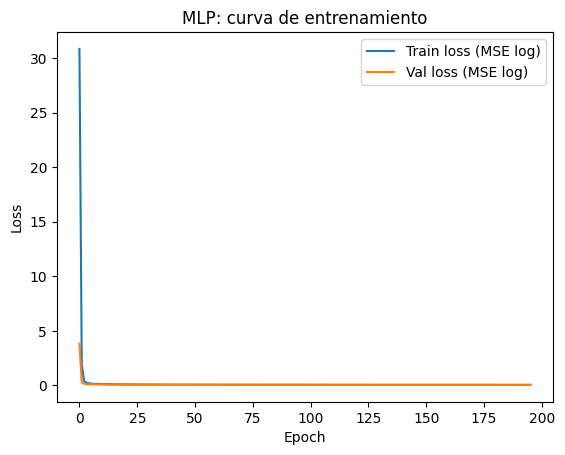

In [12]:
plt.figure()
plt.plot(history_mlp["loss"], label="Train loss (MSE log)")
plt.plot(history_mlp["val_loss"], label="Val loss (MSE log)")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("MLP: curva de entrenamiento"); plt.legend(); plt.show()

In [13]:
# ====== SHAP (robusto a versiones) ======
try:
    feature_names = list(X_df.columns)
except Exception:
    feature_names = [f"f{i}" for i in range(X_train.shape[1])]
    
NSAMPLES = 200  # número de evaluaciones por muestra en KernelExplainer

# submuestras (parametrizables)
BG_K = min(256, X_train.shape[0])   # prototipos k-means ~256
EX_N = min(512, X_test.shape[0])    # explicaciones ~512

# background representativo: prototipos k-means
try:
    background = shap.kmeans(X_train, BG_K)
except Exception:
    km = KMeans(n_clusters=BG_K, n_init=5, random_state=SEED).fit(X_train)
    background = km.cluster_centers_.astype(np.float32)

explain_X = X_test[:EX_N].astype(np.float32)

# Normalizar 'background' a ndarray (shap.kmeans -> DenseData)
if hasattr(background, "data"):  # DenseData
    background_np = np.asarray(background.data, dtype=np.float32)
else:  # ya es ndarray (p. ej., KMeans)
    background_np = background.astype(np.float32)

assert background_np.ndim == 2 and explain_X.ndim == 2

t0 = time.perf_counter()
f_pred = lambda z: model.predict(z, verbose=0).ravel()
explainer = shap.KernelExplainer(f_pred, background_np, link="identity")
sv = explainer.shap_values(explain_X, nsamples=NSAMPLES)
shap_vals = sv[0] if isinstance(sv, list) else sv
shap_vals = np.asarray(shap_vals, dtype=np.float32)

# normalizar forma a (n_samples, n_features)
if shap_vals.ndim == 1:
    shap_vals = shap_vals.reshape(-1, 1)
if shap_vals.shape[0] != explain_X.shape[0] and shap_vals.shape[1] == explain_X.shape[0]:
    shap_vals = shap_vals.T
print(
    f"[SHAP] backend=kernel | bg_n={background_np.shape[0]} | "
    f"ex_n={explain_X.shape[0]} | nsamples={NSAMPLES} | time={time.perf_counter()-t0:.2f}s"
)

# Importancias
imp = np.mean(np.abs(shap_vals), axis=0)
order = np.argsort(imp)[::-1]
top_k = 20
shap_summary = pd.DataFrame({
    "feature": np.array(feature_names)[order][:top_k],
    "mean_|shap|": imp[order][:top_k],
})
print("\nTop-20 features por |SHAP| (MLP):")
print(shap_summary.to_string(index=False))

shap_data = {
    "feature_names": feature_names,
    "importances": imp,
    "order": order,
    "topk_df": shap_summary,
}


Using 256 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/512 [00:00<?, ?it/s]

[SHAP] backend=kernel | bg_n=256 | ex_n=512 | nsamples=200 | time=2604.92s

Top-20 features por |SHAP| (MLP):
                     feature  mean_|shap|
                superficie_t     0.287232
                    longitud     0.076837
                       banos     0.060319
                     latitud     0.048515
             estacionamiento     0.026015
                 dormitorios     0.014824
arts_and_entertainment_dim00     0.013396
                  antiguedad     0.012198
     sport_and_leisure_dim00     0.011745
 food_and_drink_stores_dim00     0.007897
arts_and_entertainment_dim08     0.007031
     sport_and_leisure_dim08     0.007026
               medical_dim00     0.006566
     sport_and_leisure_dim03     0.004819
              security_dim11     0.003810
           has_education_sup     0.003774
        food_and_drink_dim02     0.003340
         education_sup_dim11     0.003317
              security_dim00     0.003304
              banos_faltante     0.002979


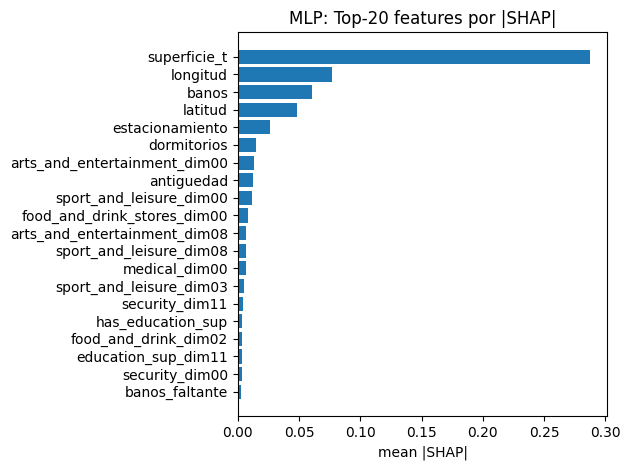

In [14]:
# Top-K SHAP bar
if shap_data:
    top = shap_data["topk_df"]
    plt.figure()
    plt.barh(top["feature"][::-1], top["mean_|shap|"][::-1])
    plt.xlabel("mean |SHAP|"); plt.title("MLP: Top-20 features por |SHAP|"); plt.tight_layout(); plt.show()

Notamos que en el top 20 de features mas importantes 12 son VCR y una el flag de presencia de VCR. Sin embargo, el peso acumulado de estas features no alcanza el 15% del valor de estas 20 features.

Comparación de resultados en MLP

El modelo basado en perceptrón multicapa (MLP) muestra un patrón de mejora consistente conforme se incorporan variables georreferenciales. El modelo de control, que utiliza únicamente atributos estructurales de las viviendas, alcanza un R² de 0.90 en el espacio logarítmico y un MAPE cercano al 20%, un desempeño comparable al obtenido por el FT-Transformer en su configuración base. La inclusión de las coordenadas de latitud y longitud produce una mejora significativa, elevando el R² a 0.95 y reduciendo el MAPE a 13.97%, lo que evidencia la alta sensibilidad del MLP para capturar las relaciones espaciales básicas a través de variables continuas. Al añadir los vectores de características de referencia (VCR), que describen el contexto urbano y la presencia de distintos puntos de interés en el entorno, el modelo logra su mejor desempeño con un R² de 0.95 y un MAPE de 13.63%. Sin embargo, la mejora respecto al modelo con solo coordenadas es marginal y se acompaña de una leve brecha entre los errores de entrenamiento y validación, lo que sugiere un ligero sobreajuste asociado al aumento de dimensionalidad del dataset. En conjunto, los resultados indican que el MLP aprovecha eficazmente la información espacial directa, mientras que los VCR aportan beneficios limitados frente a su complejidad adicional, reforzando la idea de que gran parte del valor predictivo del contexto geográfico ya está contenido en las coordenadas mismas.

#### Resultados del modelo MLP

| Modelo                                   | R² (log) | RMSE_log | MAE_log | RMSE (UF) | MAE (UF) | MAPE (%) |
|------------------------------------------|:--------:|:--------:|:-------:|----------:|---------:|---------:|
| **1) MLP (solo estructural)**            | 0.9046 | 0.2588 | 0.1951 | 2,103.72 | 1,150.57 | 20.39 |
| **2) MLP + latitud/longitud**            | 0.9521 | 0.1833 | 0.1366 | 1,651.47 | 829.88 | 13.97 |
| **3) MLP + latitud/longitud + VCR**      | 0.9540 | 0.1796 | 0.1283 | 1,642.30 | 791.70 | 13.63 |
